# clone + import + drive + paths


In [1]:
import os
run_in_colab = False

In [2]:
config = {
    'beta1' : 0.9,
    'beta2' : 0.999,
    'adverserial_D' : 2e-5,
    'adverserial_M' : 5e-6,
    'non_adverserial_lr' : 5e-5,
    'lrAttr' : 0.0001,
    'IdDiffersAttrTrainRatio' : 3, # 1/3
    'batchSize' : 4,
    'R1Param' : 10,
    'lambdaID' : 1,
    'lambdaLND' : 1,
    'lambdaREC' : 0.001,
    'a' : 0.84,
    'train_precentege' : 0.93
}
GENERATOR_IMAGE_SIZE = 1024

In [3]:
def get_base_path(run_in_colab):
    return '/content/drive/MyDrive/CNN-project-weights/' if run_in_colab else '/disk2/danielroich/yotam_disentanglement/Data/'

In [4]:
BASE_PATH = get_base_path(run_in_colab)

MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'stylegan2-ffhq-config-f.pt'
E_ID_WEIGHTS_PATH = BASE_PATH + 'resnet50_scratch_dag.pth'
IMAGE_DATA_DIR = BASE_PATH + 'fake/image/'
W_DATA_DIR = BASE_PATH + 'fake/w/'
MODELS_DIR = BASE_PATH + 'Models/'

In [5]:
def prepeare_env_for_local_use():
    CUDA_VISIBLE_DEVICES = '4'
    os.chdir('..')
    os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
    os.environ['CUDA_VISIBLE_DEVICES']= CUDA_VISIBLE_DEVICES

In [6]:
def prepeare_env_for_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content')
    !pip install pytorch-msssim
    !git clone https://github.com/danielroich/Face-Identity-Disentanglement-via-StyleGan2.git 'project'
    CODE_DIR = 'project'
    os.chdir(f'./{CODE_DIR}')

In [7]:
if run_in_colab:
    prepeare_env_for_colab()
else:
    prepeare_env_for_local_use()

In [8]:
import wandb

wandb.login()

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: daniel_roich (use `wandb login --relogin` to force relogin)


True

In [9]:
from Losses.AdversarialLoss import calc_Dw_loss
from Models.Encoders.ID_Encoder import resnet50_scratch_dag
from Models.Encoders.Attribute_Encoder import Encoder_Attribute
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Discrimanator import Discriminator
from Models.LatentMapper import LatentMapper
from Losses.NonAdversarialLoss import id_loss,landmark_loss,rec_loss
from Models.StyleGan2.model import Generator
from Utils.data_utils import get_w_image, plot_single_w_image, get_w_by_index, WDataSet, ConcatDataset, make_concat_loaders, cycle_images_to_create_diff_order
from Training.trainer import Trainer
from torch.utils.data import DataLoader,random_split
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns
sns.set()

# network + data


In [10]:
id_encoder = resnet50_scratch_dag(E_ID_WEIGHTS_PATH)
attr_encoder = Encoder_Attribute()
discriminator = Discriminator(512)
mlp = LatentMapper(4096)
landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH)
generator = Generator(GENERATOR_IMAGE_SIZE,512,8)

Using cache found in /home/danielroich/.cache/torch/hub/pytorch_vision_v0.6.0


In [11]:
state_dict = torch.load(GENERATOR_WEIGHTS_PATH)
generator.load_state_dict(state_dict['g_ema'], strict=False)

<All keys matched successfully>

In [12]:
ID_IMAGE_SIZE = id_encoder.meta['imageSize'][1]
ID_BATCH_MEAN = np.asarray(id_encoder.meta['mean']) / 255
ID_BATCH_STD = np.asarray(id_encoder.meta['std']) / 255
ATTR_IMAGE_SIZE = attr_encoder.meta['imageSize'][1]
ATTR_BATCH_MEAN = np.asarray(attr_encoder.meta['mean'])
ATTR_BATCH_STD = np.asarray(attr_encoder.meta['std'])
LANDMARK_IMAGE_SIZE = 112

In [13]:
# if len(CUDA_VISIBLE_DEVICES) > 1:
#     id_encoder = nn.DataParallel(id_encoder)
#     attr_encoder = nn.DataParallel(attr_encoder)
#     discriminator = nn.DataParallel(discriminator)
#     mlp = nn.DataParallel(mlp)
#     generator = nn.DataParallel(generator)

In [14]:
id_encoder = id_encoder.cuda()
attr_encoder = attr_encoder.cuda()
discriminator = discriminator.cuda()
mlp = mlp.cuda()
generator = generator.cuda()
landmark_encoder = landmark_encoder.cuda()

In [15]:
id_encoder = id_encoder.eval()
attr_encoder = attr_encoder.eval()
discriminator = discriminator.train()
generator = generator.train()
mlp = mlp.train()
landmark_encoder = landmark_encoder.eval()

In [16]:
id_transform=transforms.Compose([
                                transforms.Resize(ID_IMAGE_SIZE),
                                transforms.CenterCrop(ID_IMAGE_SIZE),
                                transforms.Normalize(ID_BATCH_MEAN, ID_BATCH_STD)
                                ])

attr_transform=transforms.Compose([
                                transforms.Resize(ATTR_IMAGE_SIZE),
                                transforms.CenterCrop(ATTR_IMAGE_SIZE),
                                transforms.Normalize(ATTR_BATCH_MEAN, ATTR_BATCH_STD)
                                ])

landmark_transform=transforms.Compose([transforms.Resize(LANDMARK_IMAGE_SIZE)])

In [17]:
data_dir = IMAGE_DATA_DIR

attr_dataset = dset.ImageFolder(root=data_dir, transform= transforms.ToTensor())
id_dataset = dset.ImageFolder(root=data_dir, transform= transforms.ToTensor())
w_dataset = WDataSet(W_DATA_DIR)

In [18]:
full_dataset = ConcatDataset((id_dataset, attr_dataset,w_dataset))
train_size = int(config['train_precentege'] * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = random_split(full_dataset, [train_size, test_size])

In [19]:
train_loader = DataLoader(dataset=train_data, batch_size=config['batchSize'], shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=config['batchSize'], shuffle=True)

# Training

In [24]:
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=config['adverserial_D'], betas=(config['beta1'], config['beta2']))
optimizer_adv_M = torch.optim.Adam(mlp.parameters(), lr=config['adverserial_M'], betas=(config['beta1'], config['beta2']))
optimizer_non_adv_M = torch.optim.Adam(mlp.parameters(), lr=config['non_adverserial_lr'], betas=(config['beta1'], config['beta2']))

In [25]:
# TODO: Change trainer to recieve 3 optimizers

trainer = Trainer(config, optimizer_D, optimizer_adv_M,discriminator,generator,
                  id_transform, attr_transform,landmark_transform, id_encoder, attr_encoder, None)

In [26]:
run = wandb.init(project="disantalgement_stylegan", reinit=True, config = config)

wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [27]:
id_images, attr_images, ws = next(iter((test_loader)))

id_images = id_images[0].cuda()
attr_images = attr_images[0].cuda()
cycled_attr_images = cycle_images_to_create_diff_order(attr_images).clone()
non_cycled_attr_images = attr_images.clone()
ws = ws.cuda()

with torch.no_grad():
    id_vec = torch.squeeze(id_encoder(id_transform(id_images)))
    non_cycled_attr_vec = torch.squeeze(attr_encoder(attr_transform(non_cycled_attr_images)))
    cycled_attr_vec = torch.squeeze(attr_encoder(attr_transform(cycled_attr_images)))
    non_cycled_test_vec = torch.cat((id_vec,non_cycled_attr_vec), dim=1)
    cycled_test_vec = torch.cat((id_vec,cycled_attr_vec), dim=1)

/disk2/danielroich/yotam_disentanglement/Face-Identity-Disentanglement-via-StyleGan2/Models/Encoders/ID_Encoder.py:206: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  conv2_1 = torch.add(conv2_1_1x1_proj_bn, 1, conv2_1_1x1_increase_bn)


For index 0 in test_vec we have the following input:
ID image:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


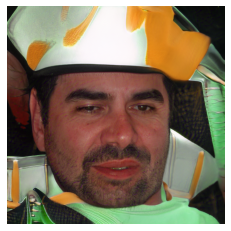

In [28]:
print('For index 0 in test_vec we have the following input:')

print('ID image:')
with torch.no_grad():
    image1 = get_w_image(ws[0], generator)
#     plot_single_w_image(ws[0], generator)
    wandb.log({"Test__ID_Image": [wandb.Image(image1, caption="ID image")]}, step = 0)


# print('Attr image:')
# image2 = get_w_image(ws[config['batchSize'] - 1], generator)
# wandb.log({"Test__Attr_Image": [wandb.Image(image2, caption="Attr image")]}, step = 0)


## Global Training

In [29]:
def mean(tensors_list):
    return sum(tensors_list) / len(tensors_list)

In [30]:
D_error_real_train = []
D_error_fake_train = []           
D_prediction_real_train = []
D_prediction_fake_train = []          
G_error_train = []
G_pred_train = []
id_loss_train = []
rec_loss_train = []
landmark_loss_train = []
total_error_train = []

  0%|          | 31/113960 [00:32<33:34:26,  1.06s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


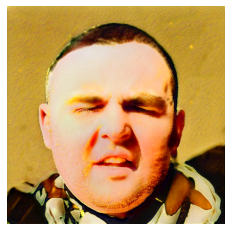

  0%|          | 61/113960 [01:04<31:49:16,  1.01s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


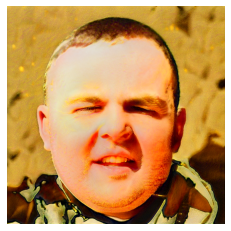

  0%|          | 91/113960 [01:35<31:41:32,  1.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


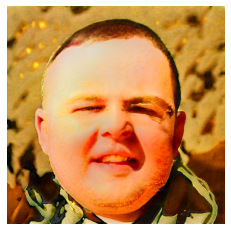

  0%|          | 121/113960 [02:07<31:19:31,  1.01it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


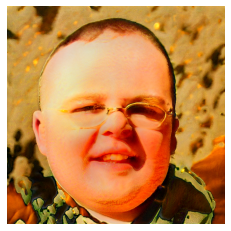

  0%|          | 151/113960 [02:39<32:41:51,  1.03s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


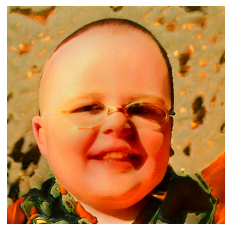

  0%|          | 181/113960 [03:11<31:44:23,  1.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


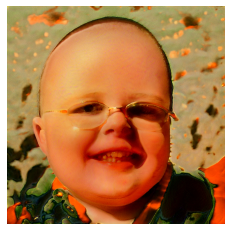

  0%|          | 211/113960 [03:42<31:39:36,  1.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


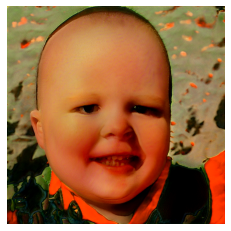

  0%|          | 241/113960 [04:14<32:00:42,  1.01s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


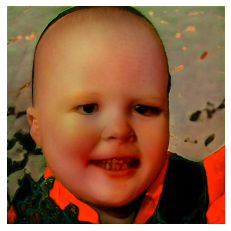

  0%|          | 271/113960 [04:46<31:13:07,  1.01it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


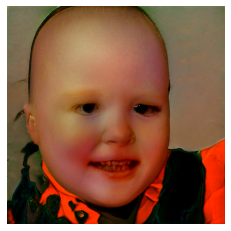

  0%|          | 301/113960 [05:17<31:59:24,  1.01s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


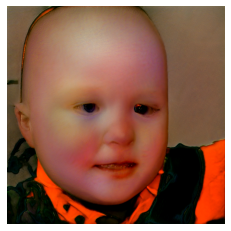

  0%|          | 331/113960 [05:49<32:21:56,  1.03s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


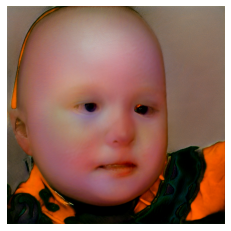

  0%|          | 361/113960 [06:22<32:25:55,  1.03s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


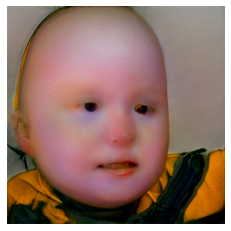

  0%|          | 391/113960 [06:54<32:32:41,  1.03s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


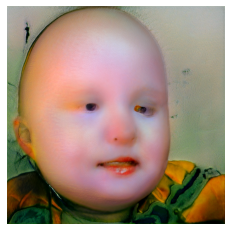

  0%|          | 421/113960 [07:26<32:16:27,  1.02s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


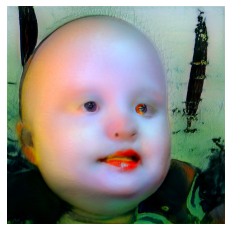

  0%|          | 451/113960 [07:58<33:35:39,  1.07s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


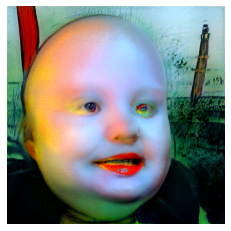

  0%|          | 481/113960 [08:29<30:58:12,  1.02it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


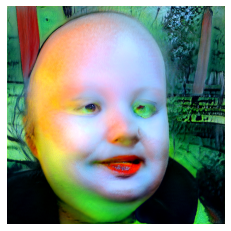

  0%|          | 511/113960 [09:02<33:09:35,  1.05s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


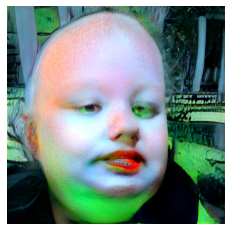

  0%|          | 541/113960 [09:34<32:00:43,  1.02s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


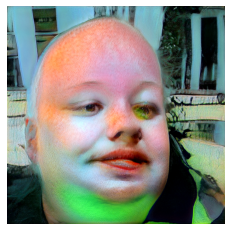

  1%|          | 571/113960 [10:05<30:54:36,  1.02it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


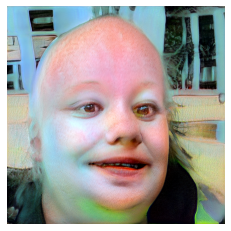

  1%|          | 601/113960 [10:37<30:42:28,  1.03it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


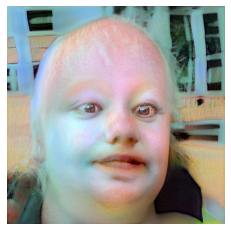

  1%|          | 631/113960 [11:08<32:41:59,  1.04s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


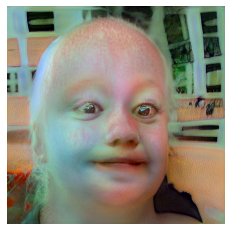

  1%|          | 661/113960 [11:40<32:01:06,  1.02s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


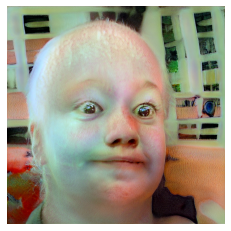

  1%|          | 691/113960 [12:11<30:18:16,  1.04it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


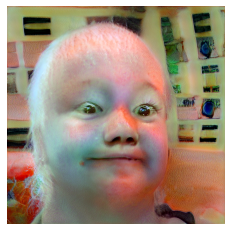

  1%|          | 717/113960 [12:41<37:57:54,  1.21s/it]

In [ ]:
epochs = 70
same_images = True
wandb_log_dict = {}
with tqdm(total=epochs * len(train_loader)) as pbar:
    for epoch in range(epochs):
        for idx, data in enumerate(train_loader):
            torch.cuda.empty_cache()
            id_images, attr_images, ws = data

            id_images = id_images[0].cuda()
            attr_images = attr_images[0].cuda()
            ws = ws.cuda()

            with torch.no_grad():
                id_vec = torch.squeeze(id_encoder(id_transform(id_images)))
                attr_vec = torch.squeeze(attr_encoder(attr_transform(attr_images)))
                try:
                    encoded_vec = torch.cat((id_vec,attr_vec), dim=1)
                except:
                    continue

            fake_data = mlp(encoded_vec)

            if idx % 2 == 0 or idx < 20:
                error_real, error_fake, prediction_real, prediction_fake, g_error, g_pred = trainer.adversarial_train_step(ws, fake_data, False)
                D_error_real_train.append(error_real.cpu().detach())
                D_error_fake_train.append(error_fake.cpu().detach())
                D_prediction_real_train.append(prediction_real.cpu().detach().mean())
                D_prediction_fake_train.append(prediction_fake.cpu().detach().mean())
                G_error_train.append(g_error.cpu().detach())
                G_pred_train.append(g_pred.cpu().detach().mean())
            else:

                generated_images, _ = generator(
                  [fake_data], input_is_latent=True, return_latents=False
                )
                generated_images = (generated_images + 1) / 2

                id_generated_images = id_transform(generated_images)

                pred_id_embedding = torch.squeeze(id_encoder(id_generated_images))
                id_loss_val = config['lambdaID'] * id_loss(id_vec, pred_id_embedding)
                id_loss_train.append(id_loss_val.cpu().detach())

                lanmkmark_attr_images = landmark_transform(attr_images) 
                lanmkmark_generated_images = landmark_transform(generated_images)

           
                generated_landmarks, generated_landmarks_nojawline = landmark_encoder(lanmkmark_generated_images)
                real_landmarks, real_landmarks_nojawline = landmark_encoder(lanmkmark_attr_images)
                landmark_loss_val = landmark_loss(generated_landmarks, real_landmarks) * config['lambdaLND']
                
                landmark_loss_train.append(landmark_loss_val.cpu().detach())
                    
                # TODO: Clip landmark loss?
                    
                rec_loss_val = config['lambdaREC'] * rec_loss(attr_images, generated_images, config['a'])
                
                rec_loss_train.append(rec_loss_val.cpu().detach())

                total_error = rec_loss_val + id_loss_val + landmark_loss_val
             
                total_error_train.append(total_error.cpu().detach())

                optimizer_non_adv_M.zero_grad()
                total_error.backward()
                optimizer_non_adv_M.step()

            pbar.update(1)
            if idx % 30 == 0 and idx != 0:
                with torch.no_grad():
#                     plot_single_w_image(mlp(non_cycled_test_vec)[0], generator)
                    wandb.log({'D_error_real_train': mean(D_error_real_train), 'D_error_fake_train': mean(D_error_fake_train),
                              'D_prediction_real_train': mean(D_prediction_real_train), 'D_prediction_fake_train': mean(D_prediction_fake_train),
                              'G_error_train': mean(G_error_train), 'G_pred_train': mean(G_pred_train),
                              'id_loss_train': mean(id_loss_train), 'rec_loss_train': mean(rec_loss_train),
                              'landmark_loss_train' : mean(landmark_loss_train), 'total_error_train': mean(total_error_train)})
                    D_error_real_train = []
                    D_error_fake_train = []           
                    D_prediction_real_train = []
                    D_prediction_fake_train = []          
                    G_error_train = []
                    G_pred_train = []
                    id_loss_train = []
                    rec_loss_train = []
                    landmark_loss_train = []
                    total_error_train = []
                    
            if idx % 240 == 0 and idx != 0:
                generated_image = get_w_image(mlp(non_cycled_test_vec)[0], generator)
                wandb.log({"Train_Images": [wandb.Image(generated_image, caption=f"generated_image{idx}")]})
                torch.save(mlp, f'{MODELS_DIR}{idx}_{time.time()}_{int(total_error)}.pt')
     